In [75]:
#Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import time
import cv2

### Histogram Computation

In [76]:
def compute_histogram(image):
    flattened_image = image.flatten()
    frequency = {i: 0 for i in range(256)}
    for pixel in flattened_image:
        frequency[pixel] += 1
    return frequency

In [77]:
coin = Image.open('coins.png')
coin_grayscale = coin.convert("L")
coin_array = np.array(coin_grayscale)
print("Image shape:", coin_array.shape)
print("Total pixels:", coin_array.size)
print(f"Max, {np.max(coin_array)}")

Image shape: (203, 248)
Total pixels: 50344
Max, 255


In [78]:
frequency = compute_histogram(coin_array)
print("Sum of frequencies:", sum(frequency.values()))

Sum of frequencies: 50344


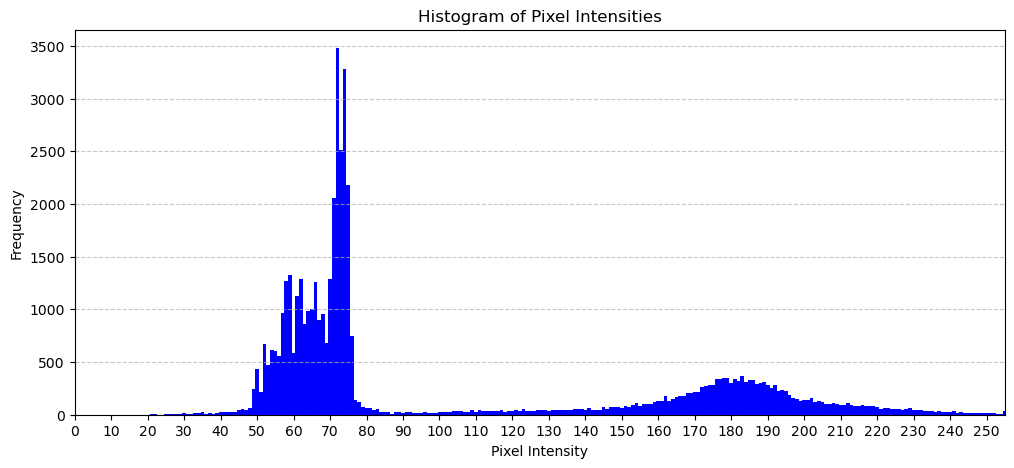

In [79]:
plt.figure(figsize=(12, 5))
plt.bar(frequency.keys(), frequency.values(), width=1, color='blue')
plt.title('Histogram of Pixel Intensities')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.xticks(np.arange(0, 256, step=10))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xlim(0, 255)
plt.show()

In [80]:
# Average pixel intensity
sum_of_pixel_intensities = sum(pixel * freq for pixel, freq in frequency.items())
average_pixel_intensity = sum_of_pixel_intensities / sum(frequency.values())
print(f"Average pixel intensity using histogram: {average_pixel_intensity:.2f}")

Average pixel intensity using histogram: 103.31


In [81]:
print(f"Average pixel intensity using numpy:, {np.mean(coin_array):.2f}")
verify = np.isclose(average_pixel_intensity, np.mean(coin_array))
print(f"If the averages from frequency distribution and numpy array are the same: {verify}")

Average pixel intensity using numpy:, 103.31
If the averages from frequency distribution and numpy array are the same: True


### Otsu’s Binarization

In [82]:
def within_class_variance(image, threshold):
    image_array = image.ravel() # Flatten image
    mn = image_array.size
    hist, bin_edge= np.histogram(image_array, bins=256, range=(0, 256))
    normalized_hist = hist / mn
    C0 = np.sum(normalized_hist[:threshold+1]) # Probability of class 0
    C1 = 1 - C0 # Probability of class 1
    if C0 > 0:
        class_0_mean = np.sum(np.arange(0, threshold+1) * normalized_hist[:threshold+1]) / C0
        class_0_variance = np.sum(((np.arange(0, threshold+1) - class_0_mean) ** 2) * normalized_hist[:threshold+1]) / C0
    else:
        class_0_mean = 0
        class_0_variance = 0

    if C1 > 0:
        class_1_mean = np.sum(np.arange(threshold+1, 256) * normalized_hist[threshold+1:]) / C1
        class_1_variance = np.sum(((np.arange(threshold+1, 256) - class_1_mean) ** 2) * normalized_hist[threshold+1:]) / C1
    else:
        class_1_mean = 0
        class_1_variance = 0
    sigmaW_squared = C0 * class_0_variance + C1 * class_1_variance # Within class variance. 
    return sigmaW_squared


In [83]:
start = time.time()
within_variance = {i:0 for i in range(256)}
min_within_class_variance = np.inf
min_index = 0
for t in range(256):
    sigmaW = within_class_variance(coin_array, t)
    if min_within_class_variance>sigmaW:
        min_within_class_variance = sigmaW
        min_index = t
    within_variance[t]=sigmaW
end = time.time()
print(f"Total time to find the optimal threshold is {end-start :.2f}")


Total time to find the optimal threshold is 0.38


In [84]:
print(f"Minimum within class variance is: {min_within_class_variance:.2f}")
print(f"The minimum within class variance is for threshold {min_index}")

Minimum within class variance is: 265.10
The minimum within class variance is for threshold 125


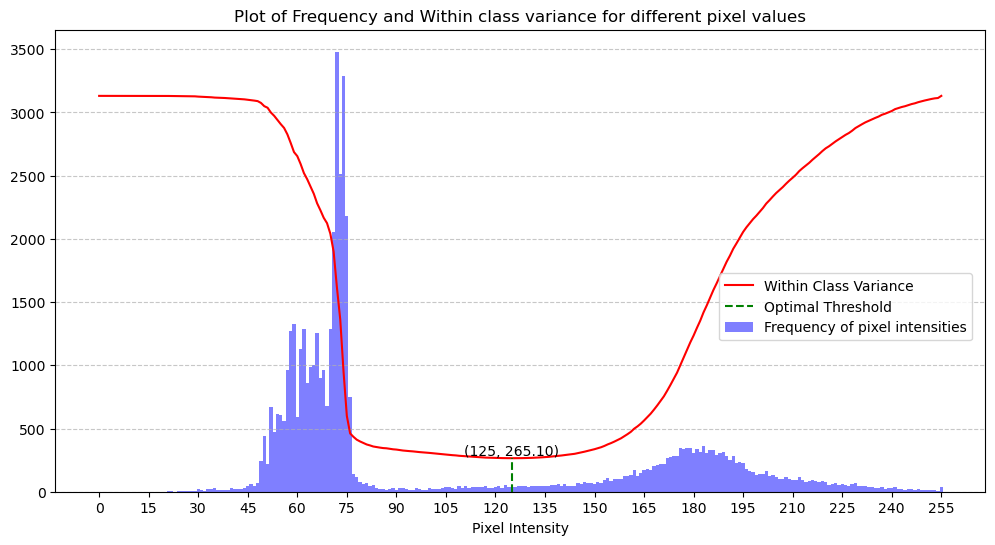

In [85]:
plt.figure(figsize=(12, 6))
plt.bar(frequency.keys(), frequency.values(), width=1, color='blue', alpha=0.5, label="Frequency of pixel intensities")
plt.plot(list(within_variance.keys()), list(within_variance.values()), color='red', label="Within Class Variance")
plt.title("Plot of Frequency and Within class variance for different pixel values")
plt.text(x=min_index, y=min_within_class_variance, s=f"({min_index}, {min_within_class_variance:.2f})", color='black', fontsize=10, ha='center', va='bottom')
plt.vlines(x=min_index, ymin=0, ymax=min_within_class_variance, color='green', linestyle='--', label='Optimal Threshold')
plt.legend(loc='center', bbox_to_anchor=(0.85, 0.4))
plt.xticks(np.arange(0, 256, step=15))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xlabel("Pixel Intensity")
plt.show()

### Image offset

In [86]:
def between_class_variance(image, threshold):
    pixels = image.ravel()
    mn = pixels.size
    hist, bins = np.histogram(pixels, bins=256, range=(0, 256))
    prob = hist / mn  # normalized histogram 

    w0 = prob[:threshold+1].sum()   # weight of class 0
    w1 = 1 - w0                     # weight of class 1

    if w0 == 0 or w1 == 0:
        return 0

    mu0 = np.dot(np.arange(0, threshold+1), prob[:threshold+1]) / w0
    mu1 = np.dot(np.arange(threshold+1, 256), prob[threshold+1:]) / w1

    return w0 * w1 * (mu0 - mu1) ** 2


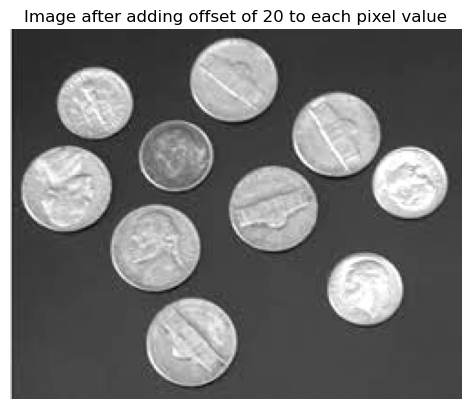

In [87]:
coin_offset = np.clip(coin_array.astype(np.int16) + 20, 0, 255).astype(np.uint8) #np.unit8 can cause overflow if value exceeds 255 then it clips the number to num%256.
# coin_offset[coin_offset>255]=255
plt.imshow(coin_offset, cmap='gray')
plt.title("Image after adding offset of 20 to each pixel value")
plt.axis('off')
plt.show()

In [88]:
print(f"Max pixel value after adding offset: {np.max(coin_offset)}")
print(f"min pixel value after adding offset: {np.min(coin_offset)}")

Max pixel value after adding offset: 255
min pixel value after adding offset: 31


In [89]:
start = time.time()
bw_variance = {i:0 for i in range(256)}
max_bw_class_variance = -np.inf
max_index = 0
for t in range(256):
    sigmaBW = between_class_variance(coin_offset, t)
    if max_bw_class_variance<sigmaBW:
        max_bw_class_variance = sigmaBW
        max_index = t
    bw_variance[t]=sigmaBW
end = time.time()
print(f"Total time to get the optimal threshold using Between class variance is {end-start :.2f}")


Total time to get the optimal threshold using Between class variance is 0.47


In [90]:
frequency={i:0 for i in range(256)}
for pixel in coin_offset.ravel():
    frequency[pixel] += 1

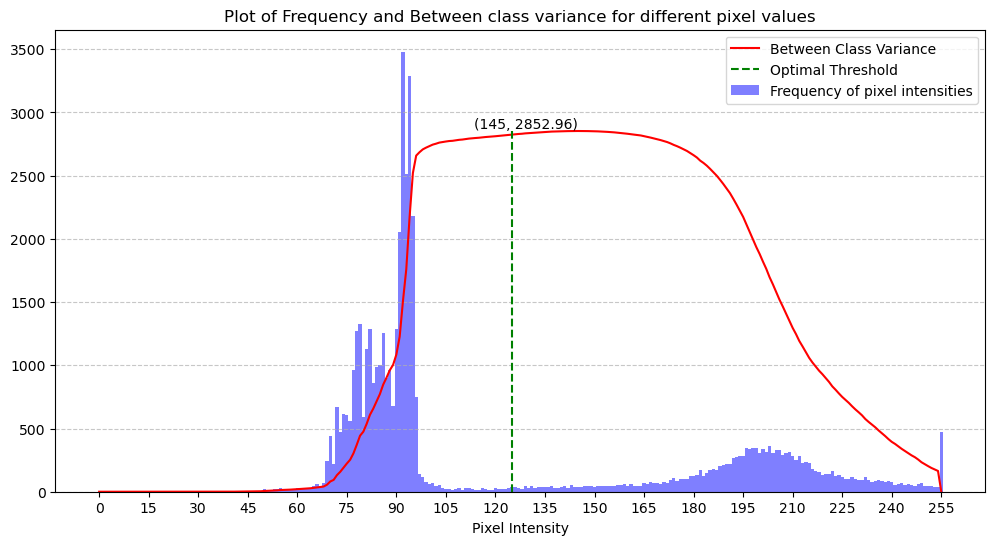

In [ ]:
plt.figure(figsize=(12, 6))
plt.bar(frequency.keys(), frequency.values(), width=1, color='blue', alpha=0.5, label="Frequency of pixel intensities")
plt.plot(list(bw_variance.keys()), list(bw_variance.values()), color='red', label="Between Class Variance")
plt.title("Plot of Frequency and Between class variance for different pixel values")
# plt.text(x=max_index, y=max_bw_class_variance, s=f"({max_index}, {max_bw_class_variance:.2f})", color='black', fontsize=10, ha='right', va='bottom')
# plt.vlines(x=min_index, ymin=0, ymax=max_bw_class_variance, color='green', linestyle='--', label='Optimal Threshold')
plt.legend(loc='upper right', bbox_to_anchor=(1, 1))
plt.xticks(np.arange(0, 256, step=15))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xlabel("Pixel Intensity")
plt.show()

In [92]:
coin_binary = coin_array
coin_binary[coin_binary<=125]=0
coin_binary[coin_binary>125]=1

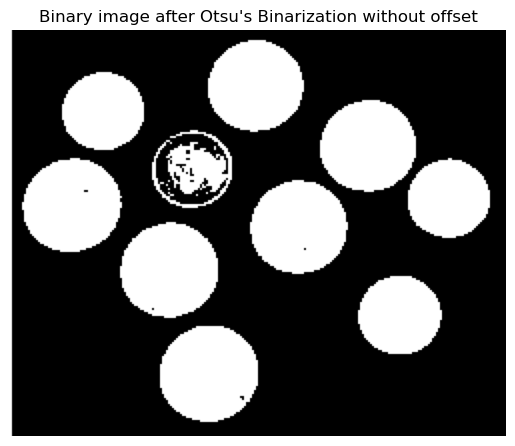

In [93]:
plt.imshow(coin_binary, cmap='gray')
plt.title("Binary image after Otsu's Binarization without offset")
plt.tight_layout()
plt.axis("off")
plt.show()


In [94]:
coin_binary_offset = coin_offset
coin_binary_offset[coin_binary_offset<=145]=0
coin_binary_offset[coin_binary_offset>145]=1

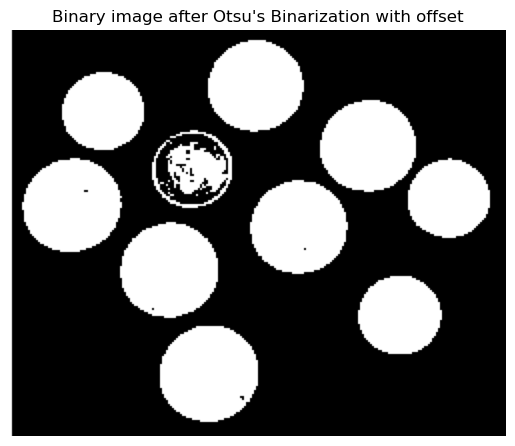

In [95]:
plt.imshow(coin_binary_offset, cmap='gray')
plt.title("Binary image after Otsu's Binarization with offset")
plt.tight_layout()
plt.axis("off")
plt.show()


### Adaptive Binarization 

In [96]:
sudoku = Image.open("sudoku.png")
sudoku_gray = sudoku.convert("L")
sudoku_array = np.array(sudoku_gray)
sudoku_flattened = sudoku_array.flatten()

#### Adaptive Binarization: Divide the image sudoku.png into overlapping blocks of specified sizes.
 Apply Otsu’s binarization independently to each block. After processing, reconstruct the full
 image by stitching the binarized blocks back together. In overlapping regions, determine the final
 pixel value using a majority vote (i.e., select the most frequent binary value , 0 or 1, at each pixel
 location across all overlapping blocks).
 Perform adaptive binarization with the following block, making sure each block overlaps the next
 one by 20%.
 (For example, if you use a 10x10 block, a 20% overlap means each block will share 2 pixels (20%
 of 10) with the next block.)
#### (a) 5 ×5
#### (b) 10 ×10
#### (c) 25 ×25
#### (d) 50 ×50
#### (e) The full image (i.e., global binarization)

In [97]:
def compute_threshold(image):
    max_index = 0
    max_bw_class_variance = -np.inf
    for t in range(256):
        sigmaBW = between_class_variance(image, t)
        if max_bw_class_variance < sigmaBW:
            max_bw_class_variance = sigmaBW
            max_index = t
    return max_index

In [98]:
def adaptive_binarization(image, N, overlap=0.2):
    m, n = image.shape
    stride = int(N * (1 - overlap))

    # Vote accumulators
    vote_sum = np.zeros((m, n), dtype=np.uint16)   # how many times pixel voted 1
    vote_count = np.zeros((m, n), dtype=np.uint16) # how many times pixel was seen

    for i in range(0, m, stride):
        for j in range(0, n, stride):
            x1, y1 = i, j
            x2, y2 = min(i + N, m), min(j + N, n)
            block = image[x1:x2, y1:y2]
            threshold = compute_threshold(block)
            binary_block = (block > threshold).astype(np.uint8)
            # Accumulate votes
            vote_sum[x1:x2, y1:y2] += binary_block
            vote_count[x1:x2, y1:y2] += 1
    binary_image = (vote_sum >= (vote_count / 2)).astype(np.uint8)
    return binary_image * 255


In [99]:
m,n = sudoku_array.shape
total_blocks = []
blocks = [5,10,25,50, sudoku_array.shape[0]]
overlap = 0.2
for N in blocks:
    count = 0
    stride = int(N * (1 - overlap))
    for i in range(0,m, stride):
        for j in range(0,n, stride):
            count += 1
    total_blocks.append(count)
            
total_blocks

[16384, 4096, 676, 169, 4]

In [100]:
times_for_N = []

In [ ]:
# Ensure times_for_N has the same length as blocks
if len(times_for_N) != len(blocks):
	times_for_N = [0] * len(blocks)  # Fill with zeros if not already populated

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.bar([str(block) for block in blocks], total_blocks, color='blue', alpha=0.7)
plt.title("Number of blocks for different block sizes")
plt.xlabel("Block size (N x N)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylabel("Number of blocks")
plt.subplot(1, 2, 2)
plt.bar([str(block) for block in blocks], times_for_N, color='red', alpha=0.5)
plt.title("Time taken for different block sizes")
plt.xlabel("Block size (N x N)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylabel("Time (seconds)")
plt.show()

Time taken for block size 5 is 911.81 seconds


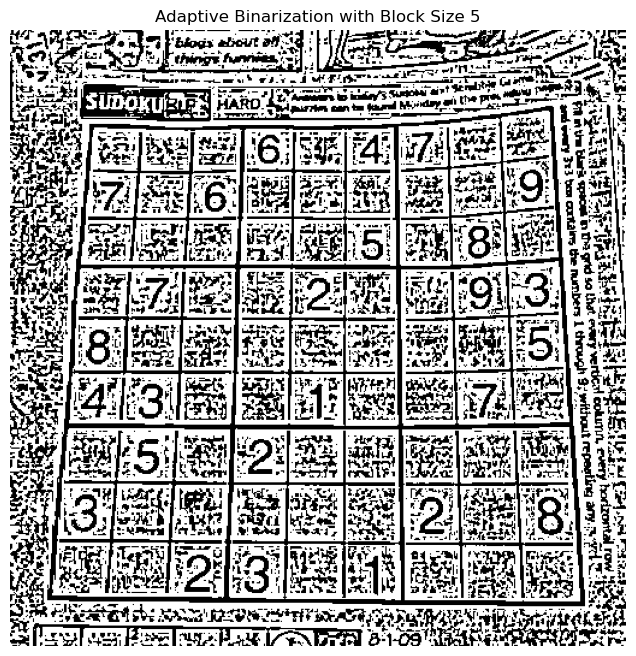

Time taken for block size 10 is 310.30 seconds


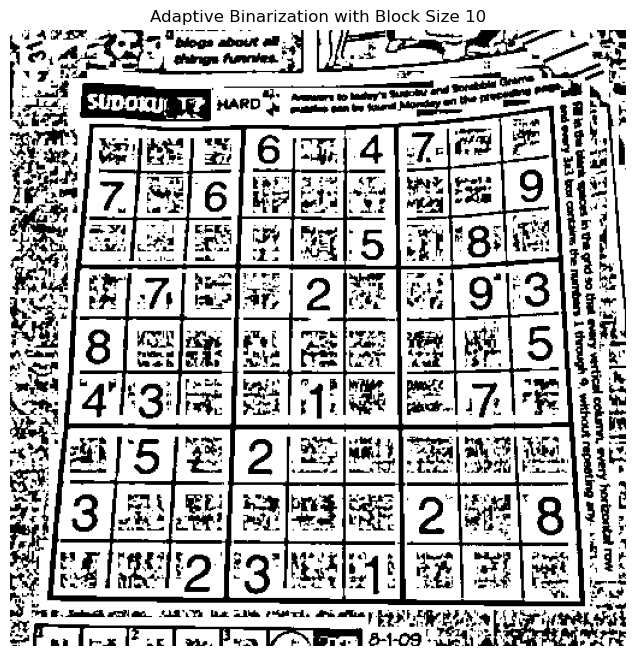

Time taken for block size 25 is 64.90 seconds


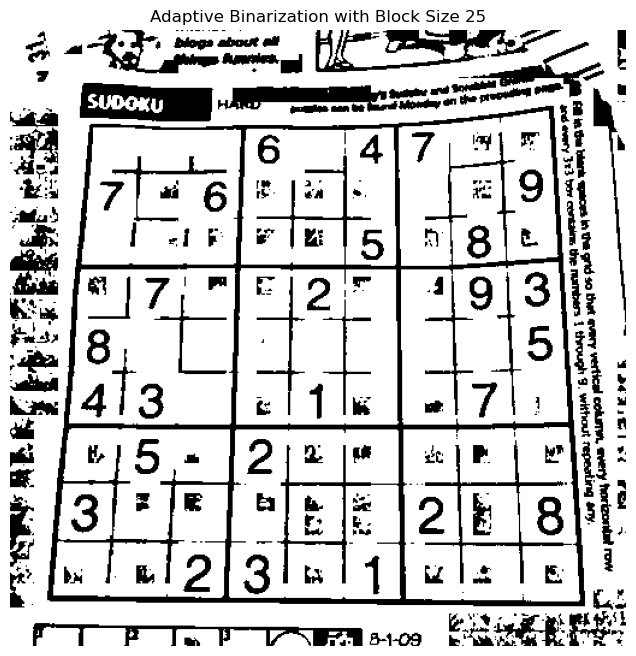

Time taken for block size 50 is 19.74 seconds


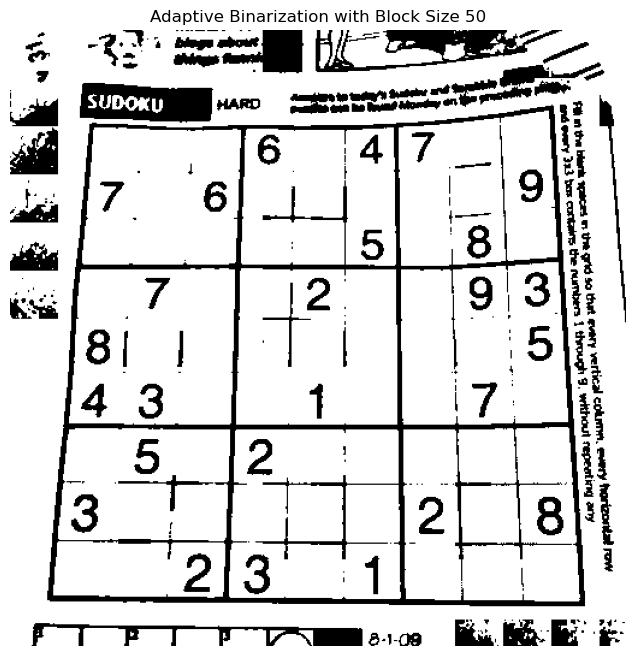

Time taken for block size 512 is 3.75 seconds


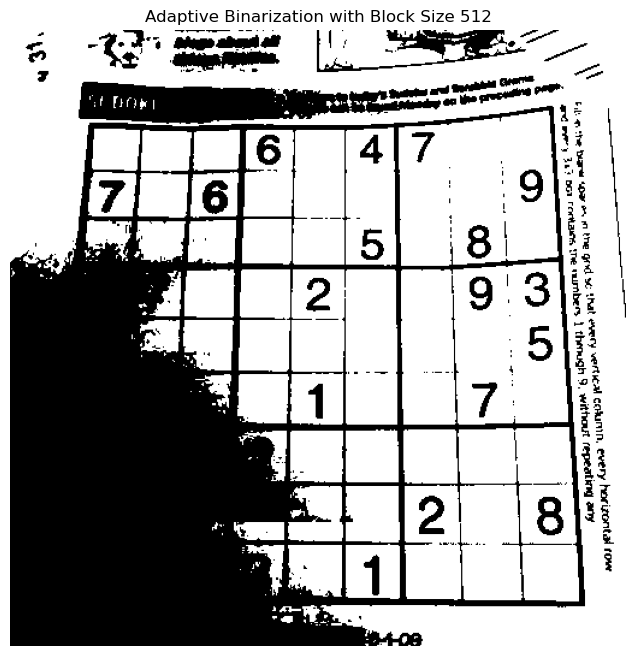

In [107]:
blocks = [5,10,25,50,sudoku_array.shape[0]]
for N in blocks:
    start = time.time()
    binarized_image = adaptive_binarization(sudoku_array, N)
    end = time.time()
    print(f"Time taken for block size {N} is {end-start:.2f} seconds")
    times_for_N.append(end-start)
    plt.figure(figsize=(8, 8))
    plt.imshow(binarized_image, cmap='gray')
    plt.title(f'Adaptive Binarization with Block Size {N}')
    plt.axis('off')
    plt.show()

### Connected Components

The optimal threshold for quote image is 142


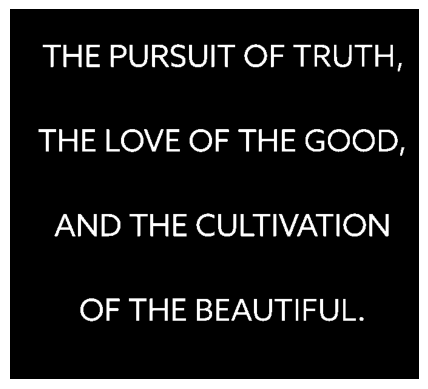

In [103]:
quote = Image.open("quote.png")
quote_gray = quote.convert("L")
quote_array = np.array(quote_gray)
optimal_threshold = compute_threshold(quote_array)
print(f"The optimal threshold for quote image is {optimal_threshold}")
quote_array[quote_array<=optimal_threshold]=1
quote_array[quote_array>optimal_threshold]=0
plt.imshow(quote_array, cmap='gray')
plt.axis('off')
plt.show()


In [104]:
def connected_components_8(binary):
    h, w = binary.shape
    labels = np.zeros((h, w), dtype=np.int32)
    next_label = 1
    parent = {}

    def find(x):
        while parent[x] != x:
            parent[x] = parent[parent[x]]
            x = parent[x]
        return x

    def union(x, y):
        rootX, rootY = find(x), find(y)
        if rootX != rootY:
            parent[rootY] = rootX

    for y in range(h):
        for x in range(w):
            if binary[y, x] == 1:
                neighbours = []
                if y > 0:
                    neighbours.append(labels[y-1, x])          # top
                    if x > 0: neighbours.append(labels[y-1, x-1])  # top-left
                    if x < w-1: neighbours.append(labels[y-1, x+1])# top-right
                if x > 0:
                    neighbours.append(labels[y, x-1])          # left

                neighbours = [n for n in neighbours if n > 0]

                if not neighbours:
                    labels[y, x] = next_label
                    parent[next_label] = next_label
                    next_label += 1
                else:
                    min_label = min(neighbours)
                    labels[y, x] = min_label
                    for n in neighbours:
                        if n != min_label:
                            union(min_label, n)

    flatmap = {lab: find(lab) for lab in parent.keys()}
    labels = np.vectorize(flatmap.get)(labels, 0)

    return labels

In [105]:
def highlight_largest_character(img_path = "quote.png"):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    _, binary = cv2.threshold(img, optimal_threshold, 1, cv2.THRESH_BINARY_INV)
    labels = connected_components_8(binary)
    unique, counts = np.unique(labels, return_counts=True)
    label_sizes = dict(zip(unique, counts))
    label_sizes.pop(0, None)
    border_labels = np.unique(np.concatenate([labels[0,:], labels[-1,:], labels[:,0], labels[:,-1]]))
    for b in border_labels:
        label_sizes.pop(b, None)

    mean_size = np.mean(list(label_sizes.values()))
    filtered = {k:v for k,v in label_sizes.items() if v > 0.5*mean_size}
    if not filtered:
        print("No characters found")
        return img
    largest_label = max(filtered, key=filtered.get)
    mask = (labels == largest_label)
    out = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    out[mask] = [255,0,0]
    return out


Number of connected components in the binary image is 145


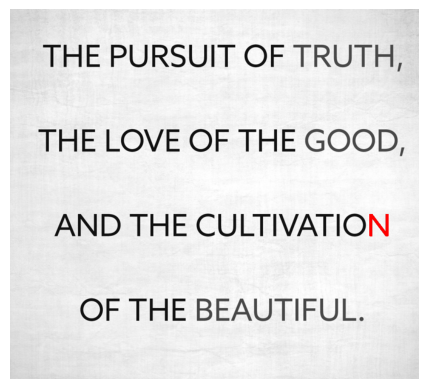

In [106]:
result = highlight_largest_character("quote.png")
labeled_image = connected_components_8(quote_array)
num_labels = labeled_image.max()
print(f"Number of connected components in the binary image is {num_labels}")
plt.imshow(result, cmap='gray') 
plt.axis('off')
plt.show()